This notebook find DDSM and corresponging CBIS-DDSM images.

The idea is:
1. Use size, laterality and view to find the possible candidates.
2. For each candidate, calculate the similarity between the images.

It is important to consider, that intensity normalization is different. For these reason CBIS ddsm are renormalized using the same method as DDSM (dezso method). This improves a lot the quality of the similarity.



In [5]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
data_folder = pathlib.Path('/home/alalbiol/Data/mamo')
data_folder = pathlib.Path('/media/HD/mamo')
cbis_ddsm_path = data_folder / 'CBIS-DDSM'
ddsm_path = data_folder / 'DDSM_png'

In [7]:
all_cbis_images = list(cbis_ddsm_path.glob('**/*.png'))
print(f'CBIS-DDSM images: {len(all_cbis_images)}')
all_ddsm_images = list(ddsm_path.glob('**/*.png'))
print(f'DDSM images: {len(all_ddsm_images)}')

CBIS-DDSM images: 10239
DDSM images: 10420


In [8]:
calc_case_test = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_test_set.csv')
calc_case_train = pd.read_csv( '../resources/cbis_ddsm/calc_case_description_train_set.csv')
mass_case_test = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_test_set.csv')
mass_case_train = pd.read_csv( '../resources/cbis_ddsm/mass_case_description_train_set.csv')
all_case_train = pd.concat([calc_case_train, mass_case_train])
all_case_test = pd.concat([calc_case_test, mass_case_test])
all_case = pd.concat([all_case_train, all_case_test])

print(f'calc_case_test: {len(calc_case_test)}')
print(f'calc_case_train: {len(calc_case_train)}')
print(f'mass_case_test: {len(mass_case_test)}')
print(f'mass_case_train: {len(mass_case_train)}')
print(f'all_case_train: {len(all_case_train)}')
print(f'all_case_test: {len(all_case_test)}')
print(f'all_case: {len(all_case)}')


calc_case_test: 326
calc_case_train: 1546
mass_case_test: 378
mass_case_train: 1318
all_case_train: 2864
all_case_test: 704
all_case: 3568


In [9]:
#create data frame with all ddsm images
ddsm_images = pd.DataFrame(all_ddsm_images, columns=['image_path'])
def get_image_size(image_path):
    image = Image.open(image_path)
    return image.size

def lat_orientation(image_path):
    name = image_path.stem
    return  name.split('.')[-1]

ddsm_images['image_size'] = ddsm_images['image_path'].apply(get_image_size)
ddsm_images['lat_orientation'] = ddsm_images['image_path'].apply(lat_orientation)

In [10]:
ddsm_images.lat_orientation.value_counts()

lat_orientation
LEFT_CC      2605
RIGHT_CC     2605
RIGHT_MLO    2605
LEFT_MLO     2605
Name: count, dtype: int64

In [11]:
def set_id(row):
    im_size = f"{row['image_size'][0]}_{row['image_size'][1]}"
    return f"{row['lat_orientation']}_{im_size}"

ddsm_images['id'] = ddsm_images.apply(set_id, axis=1)

In [13]:
print(len(ddsm_images.id.unique()))
print(len(ddsm_images)) # tenemos casi identificada cada imagen con esta firma basada en tamaño y orientación

9026
10420


In [14]:
def has_overlay(image_path):
    overlay_file = image_path.with_suffix('.OVERLAY')
    return overlay_file.exists()

ddsm_images['has_overlay'] = ddsm_images['image_path'].apply(has_overlay)
ddsm_images['has_overlay'].value_counts()

has_overlay
False    6391
True     4029
Name: count, dtype: int64

In [16]:
ddsm_images_candidates = ddsm_images[ddsm_images['has_overlay']]

# candidatos de encontrar en el directorio de cbis-ddsm
print("Numero de imagenes con overlay ", len(ddsm_images_candidates))
print("numero de imagenes en ddsm", len(ddsm_images))

# como hay menos ids, algunas imagenes puede corresponder a varios en cbis o alreves
print("numero de ids", len(ddsm_images_candidates.id.unique()))



Numero de imagenes con overlay  4029
numero de imagenes en ddsm 10420
numero de ids 3712


In [17]:
# repetimos el proceso para cbis-ddsm
def image_size(filename):
    filename = cbis_ddsm_path / filename
    parent_folder = filename.parent
    filename = parent_folder / '000000.png'
    image = Image.open(filename)
    return image.size

all_case['image_size'] = all_case['image file path'].apply(image_size)
print(len(all_case['image_size'].unique()))
print(len(all_case['image_size']))


2621
3568


In [18]:
def set_id_cbis(row):
    im_size = f"{row['image_size'][0]}_{row['image_size'][1]}"
    return f"{row['left or right breast']}_{row['image view']}_{im_size}"

all_case['id'] = all_case.apply(set_id_cbis, axis=1)

print(len(all_case['id'].unique()))
print(len(all_case))


2875
3568


In [19]:
ddsm_images['id'].head()

0      LEFT_CC_3241_5341
1     RIGHT_CC_3526_5326
2    RIGHT_MLO_3751_5386
3     LEFT_MLO_3196_5326
4      LEFT_CC_1831_3886
Name: id, dtype: object

In [20]:
# cbis
all_case['id'].head()

0     RIGHT_CC_2761_5056
1    RIGHT_MLO_2836_5386
2      LEFT_CC_2986_5356
3     LEFT_MLO_3166_5491
4      LEFT_CC_3064_4568
Name: id, dtype: object

In [22]:
def find_ddsm_image(row):
    cbis_id = row['id'] 
    # solo buscamos candidatos con misma firma tamaño y orientación y lateralidad
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'warning: No candidate for {cbis_id}')
        return None
    
    return candidates.values
    

all_case['ddsm_image'] = all_case.apply(find_ddsm_image, axis=1)

Todos los casos de cbis tienen una imagen en ddsm porque no hay ningun warning. En la siguiente celda vemos que hay unos pocos con varios candidatos

In [23]:


all_case.ddsm_image.apply(lambda x: len(x) if x is not None else 0).value_counts()

ddsm_image
1    3145
2     315
3      71
4      30
6       5
5       2
Name: count, dtype: int64

In [24]:
def maximum_signature(image):
    # set all pixel values with the max value to 1 and the rest to 0
    image = image.flatten()
    max_value = np.max(image)
    image_max = np.where(image == max_value, 1, 0)
    min_value = np.min(image)
    image_min = np.where(image == min_value, -1, 0)
    return image_max 

def find_ddsm_image_corr(row):
    cbis_id = row['id'] 
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'No candidate for {cbis_id}')
        return None
    
    if len(candidates) == 1:
        return candidates.values[0]
    
    cbis_image_filename = cbis_ddsm_path / row['image file path']
    cbis_image_filename = cbis_image_filename.parent / '000000.png'
    cbis_image = np.array(Image.open(cbis_image_filename)).flatten()
    
    cbis_image_signature = maximum_signature(cbis_image)
    
    for candidate in candidates:
        ddsm_image = Image.open(candidate)
        ddsm_image = np.array(ddsm_image).flatten()
        
        ddsm_image_signature = maximum_signature(ddsm_image)
        # correlation
        corr = (cbis_image_signature * ddsm_image_signature).sum() / np.abs(cbis_image_signature).sum()
        print(f'{candidate} - {corr}')
        
    print('----------------')
    return cbis_image_filename, candidates.values
    
 


Voy a pintar un ejemplo con dos candidatos

/media/HD/mamo/DDSM_png/benigns/benign_02/case1326/A_1326_1.LEFT_CC.png - 1.0
/media/HD/mamo/DDSM_png/benigns/benign_12/case1884/A_1884_1.LEFT_CC.png - 0.9641491486730714
----------------
/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.201322325113694962619881476352450072222/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/000000.png
[PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_02/case1326/A_1326_1.LEFT_CC.png')
 PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_12/case1884/A_1884_1.LEFT_CC.png')]
-------------------


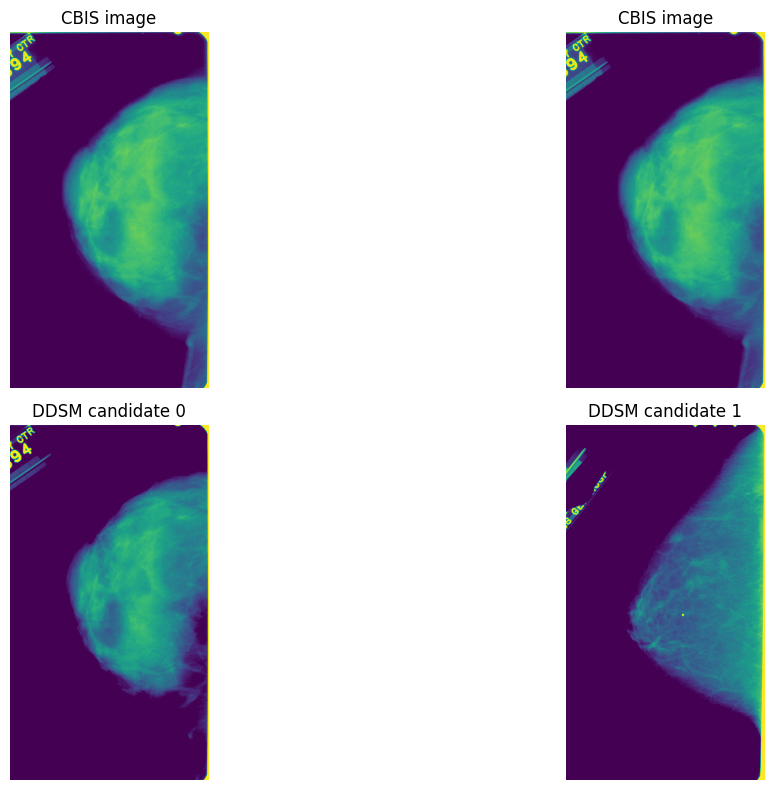

In [29]:
for idx, row in all_case.iterrows():
    ddsm_candidates = find_ddsm_image_corr(row)
    if isinstance(ddsm_candidates,tuple):
        print(ddsm_candidates[0])
        print(ddsm_candidates[1])
        print("-------------------")
        break
    
# Plot in the first row the CBIS image and in the second row all candidates
num_candidates = len(ddsm_candidates[1])
fig, ax = plt.subplots(2, num_candidates, figsize=(15, 8))  # Adjust figure size as needed

# Plot CBIS image in the first row (span across all columns)
cbis_image = np.array(Image.open(ddsm_candidates[0]), dtype=float)
for i in range(num_candidates):
    ax[0, i].imshow(cbis_image / cbis_image.max())
    ax[0, i].set_title('CBIS image')
    ax[0, i].axis('off')  # Hide axis if desired

# Plot all DDSM candidates in the second row
for i, candidate in enumerate(ddsm_candidates[1]):
    ddsm_image = np.array(Image.open(candidate), dtype=float)
    
    ax[1, i].imshow(ddsm_image / ddsm_image.max())
    ax[1, i].set_title(f'DDSM candidate {i}')
    ax[1, i].axis('off')  # Hide axis if desired

plt.tight_layout()
plt.show() 
    
#all_case['ddsm_image'] = all_case.apply(find_ddsm_image, axis=1)

Se observa la diferente normalizacion de intensidad que introdujo Dezso. 

In [33]:
ddsm_candidates

(PosixPath('/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.201322325113694962619881476352450072222/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/000000.png'),
 array([PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_02/case1326/A_1326_1.LEFT_CC.png'),
        PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_12/case1884/A_1884_1.LEFT_CC.png')],
       dtype=object))

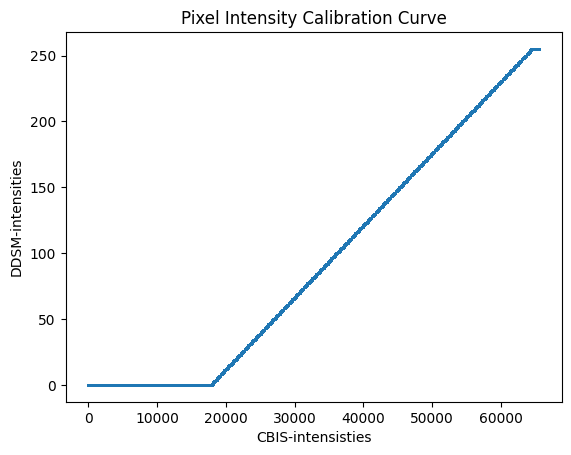

In [35]:
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial


cbis_image = np.array(Image.open(ddsm_candidates[0]), dtype=float)

# elijo el cero viendo la figura anterior
ddsm_image = np.array(Image.open(ddsm_candidates[1][0]), dtype=float)


# Assume img1 and img2 are your images flattened into 1D arrays
# They must have the same shape and corresponding pixel intensities
img1_flat = cbis_image.flatten()

img2_flat = ddsm_image.flatten()

# Scatter plot of corresponding pixel intensities
plt.scatter(img1_flat, img2_flat, s=1, alpha=0.5)
plt.xlabel('CBIS-intensisties')
plt.ylabel('DDSM-intensities')
plt.title('Pixel Intensity Calibration Curve')
plt.show()


In [36]:
def normalize_intensity(image):
    # (image - image.min()) / (image.max() - image.min())
    image = (image - image.min()) / (image.max() - image.min())
    return image

def normalize_intensity_cbis(image):
    # esta era la funcion que puso Dezso que es la que hace que se diferencie
    # el clip es muy cuestionable
    im=3*(image/65535.)
    im=np.clip(im,0.8,2.9)-0.8
    return normalize_intensity(im)
    

def find_ddsm_image_corr(row):
    cbis_id = row['id'] 
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'No candidate for {cbis_id}')
        return None
    
    if len(candidates) == 1:
        return candidates.values[0]
    
    cbis_image_filename = cbis_ddsm_path / row['image file path']
    cbis_image_filename = cbis_image_filename.parent / '000000.png'
    cbis_image = np.array(Image.open(cbis_image_filename)).flatten()
    
    cbis_image_signature = normalize_intensity_cbis(cbis_image)
    
    for candidate in candidates:
        ddsm_image = Image.open(candidate)
        ddsm_image = np.array(ddsm_image).flatten()
        
        ddsm_image_signature = normalize_intensity(ddsm_image)
        # correlation
        corr = np.mean(np.abs(cbis_image_signature - ddsm_image_signature))
        print(f'{candidate} - {corr}')
        
    print('----------------')
    return cbis_image_filename, candidates.values
    
 
for idx, row in all_case.iterrows():
    ddsm_candidates = find_ddsm_image_corr(row)
    if isinstance(ddsm_candidates,tuple):
        print(ddsm_candidates[0])
        print(ddsm_candidates[1])
        print("-------------------")
        break
    


/media/HD/mamo/DDSM_png/benigns/benign_02/case1326/A_1326_1.LEFT_CC.png - 0.005774892380405682
/media/HD/mamo/DDSM_png/benigns/benign_12/case1884/A_1884_1.LEFT_CC.png - 0.10385327294100649
----------------
/media/HD/mamo/CBIS-DDSM/Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.201322325113694962619881476352450072222/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/000000.png
[PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_02/case1326/A_1326_1.LEFT_CC.png')
 PosixPath('/media/HD/mamo/DDSM_png/benigns/benign_12/case1884/A_1884_1.LEFT_CC.png')]
-------------------


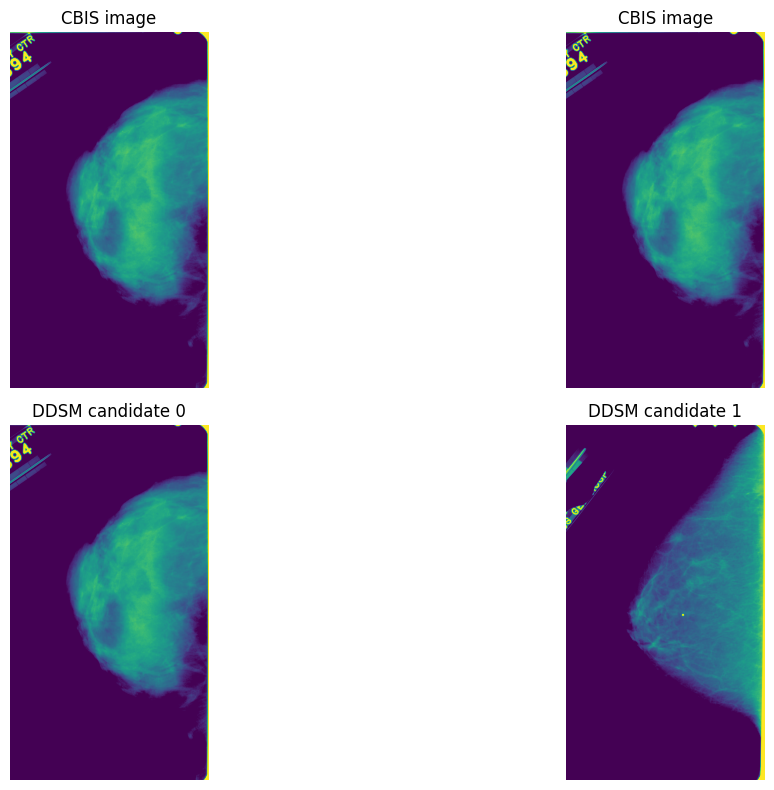

In [37]:
# Plot in the first row the CBIS image and in the second row all candidates
num_candidates = len(ddsm_candidates[1])
fig, ax = plt.subplots(2, num_candidates, figsize=(15, 8))  # Adjust figure size as needed

# Plot CBIS image in the first row (span across all columns)
cbis_image = np.array(Image.open(ddsm_candidates[0]), dtype=float)
for i in range(num_candidates):
    ax[0, i].imshow(normalize_intensity_cbis(cbis_image))
    ax[0, i].set_title('CBIS image')
    ax[0, i].axis('off')  # Hide axis if desired

# Plot all DDSM candidates in the second row
for i, candidate in enumerate(ddsm_candidates[1]):
    ddsm_image = np.array(Image.open(candidate), dtype=float)
    
    ax[1, i].imshow(normalize_intensity(ddsm_image))
    ax[1, i].set_title(f'DDSM candidate {i}')
    ax[1, i].axis('off')  # Hide axis if desired

plt.tight_layout()
plt.show() 



Con la normalizacion de intensidad de Dezso, la correspondiente es muy evidente.
Emplearemos esta normalizacion en CBIS para buscar la correspondencia con DDSM en los casos dudosos

In [28]:
from tqdm import tqdm

def cbis_ddsm_distance(cbis_filename, ddsm_filename):
    cbis_image = np.array(Image.open(cbis_filename)).flatten()
    ddsm_image = np.array(Image.open(ddsm_filename)).flatten()
    
    cbis_image_signature = normalize_intensity_cbis(cbis_image)
    ddsm_image_signature = normalize_intensity(ddsm_image)
    
    return np.mean(np.abs(cbis_image_signature - ddsm_image_signature))

def find_ddsm_image_calibrated(row):
    cbis_id = row['id'] 
    candidates = ddsm_images_candidates[ddsm_images_candidates['id'] == cbis_id].image_path
    
    if len(candidates) == 0:
        print(f'No candidate for {cbis_id}')
        return None
    cbis_image_filename = cbis_ddsm_path / row['image file path']
    cbis_image_filename = cbis_image_filename.parent / '000000.png'
    cbis_image = np.array(Image.open(cbis_image_filename)).flatten()
    
    if len(candidates) == 1:
        distance = cbis_ddsm_distance(cbis_image_filename, candidates.values[0])
        
        return {"cbis_image": row['image file path'], "ddsm_image":  candidates.values[0], "distance": distance}
    
    
    cbis_image_signature = normalize_intensity_cbis(cbis_image)
    
    min_dist = 1e6
    best_candidate = None
    
    for candidate in candidates:
        ddsm_image = Image.open(candidate)
        ddsm_image = np.array(ddsm_image).flatten()
        
        ddsm_image_signature = normalize_intensity(ddsm_image)
        # correlation
        corr = np.mean(np.abs(cbis_image_signature - ddsm_image_signature))
        if corr < min_dist:
            min_dist = corr
            best_candidate = candidate
        #print(f'{candidate} - {corr}')
        
    #print(f'---------------- best candidate of {len(candidates)}: {best_candidate} - {min_dist}')
    return {"cbis_image": row['image file path'], "ddsm_image": best_candidate, "distance": min_dist}
    
 
matches = []


import time
start = time.time()
num_rows = len(all_case)
for idx, row in all_case.iterrows():
    match = find_ddsm_image_calibrated(row)
    
    # if idx > 60:
    #     break
    if idx > 0 and idx % 20 == 0:
        elapsed = time.time() - start
        expected_remaining = elapsed * (num_rows-idx) / idx
        print(f'Processed {idx}/{num_rows}. Elapsed time: {elapsed} expected remaining: {expected_remaining}')
        df_matches = pd.DataFrame(matches)
        df_matches.to_csv('matches.csv', index=False)

    matches.append(match)
elapsed = time.time() - start
print(f'Elapsed time: {elapsed}')
    
df_matches = pd.DataFrame(matches)
df_matches.to_csv('matches.csv', index=False)


Processed 20/3568. Elapsed time: 25.003263235092163 expected remaining: 4435.57889790535
Processed 40/3568. Elapsed time: 60.18844389915466 expected remaining: 5308.6207519054415
Processed 60/3568. Elapsed time: 90.84573674201965 expected remaining: 5311.447408183416
Processed 80/3568. Elapsed time: 117.76296162605286 expected remaining: 5134.465126895904
Processed 100/3568. Elapsed time: 145.70142364501953 expected remaining: 5052.925372009277
Processed 120/3568. Elapsed time: 160.5427167415619 expected remaining: 4612.927394374212
Processed 140/3568. Elapsed time: 193.37871408462524 expected remaining: 4735.015942014967
Processed 160/3568. Elapsed time: 230.62287020683289 expected remaining: 4912.26713540554
Processed 180/3568. Elapsed time: 263.7326989173889 expected remaining: 4964.035466289521
Processed 200/3568. Elapsed time: 293.18303775787354 expected remaining: 4937.20235584259
Processed 220/3568. Elapsed time: 324.39086961746216 expected remaining: 4936.6392339966515
Processe

/tmp/ipykernel_2853412/3198710465.py:3: RuntimeWarning: invalid value encountered in divide
  image = (image - image.min()) / (image.max() - image.min())


Processed 540/3568. Elapsed time: 804.3498785495758 expected remaining: 4510.3174671261395
Processed 560/3568. Elapsed time: 832.0998089313507 expected remaining: 4469.5646879741125
Processed 580/3568. Elapsed time: 866.7160642147064 expected remaining: 4465.082068747488
Processed 600/3568. Elapsed time: 897.5507278442383 expected remaining: 4439.8842670694985
Processed 620/3568. Elapsed time: 931.1863100528717 expected remaining: 4427.640712961073
Processed 640/3568. Elapsed time: 955.0854263305664 expected remaining: 4369.515825462341
Processed 660/3568. Elapsed time: 980.9619884490967 expected remaining: 4322.1779733484445
Processed 680/3568. Elapsed time: 1016.6790342330933 expected remaining: 4317.895663037019
Processed 700/3568. Elapsed time: 1054.9211621284485 expected remaining: 4322.1627042634145
Processed 720/3568. Elapsed time: 1098.7706015110016 expected remaining: 4346.248157087962
Processed 740/3568. Elapsed time: 1140.7643427848816 expected remaining: 4359.5696775616825


In [29]:
df_matches.sort_values('distance', ascending=False).head(10)

,cbis_image,ddsm_image,distance
3111,Calc-Test_P_01536_RIGHT_MLO/1.3.6.1.4.1.9590.1...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.032941
674,Calc-Training_P_00852_LEFT_MLO/1.3.6.1.4.1.959...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.026210
1378,Calc-Training_P_01809_LEFT_MLO/1.3.6.1.4.1.959...,/media/HD/mamo/DDSM_png/cancers/cancer_04/case...,0.020907
887,Calc-Training_P_01128_RIGHT_MLO/1.3.6.1.4.1.95...,/media/HD/mamo/DDSM_png/cancers/cancer_04/case...,0.018731
688,Calc-Training_P_00862_LEFT_MLO/1.3.6.1.4.1.959...,/media/HD/mamo/DDSM_png/cancers/cancer_04/case...,0.017926
289,Calc-Training_P_00410_RIGHT_MLO/1.3.6.1.4.1.95...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.017640
2118,Mass-Training_P_00815_LEFT_MLO/1.3.6.1.4.1.959...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.017116
734,Calc-Training_P_00933_LEFT_MLO/1.3.6.1.4.1.959...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.017091
2174,Mass-Training_P_00901_RIGHT_MLO/1.3.6.1.4.1.95...,/media/HD/mamo/DDSM_png/cancers/cancer_04/case...,0.016965
202,Calc-Training_P_00288_RIGHT_MLO/1.3.6.1.4.1.95...,/media/HD/mamo/DDSM_png/cancers/cancer_03/case...,0.016666


In [ ]:
def plot_matches(row):
    cbis_image_filename = cbis_ddsm_path / row['cbis_image']
    cbis_image_filename = cbis_image_filename.parent / '000000.png'
    cbis_image = np.array(Image.open(cbis_image_filename), dtype=float)
    ddsm_image = np.array(Image.open(row['ddsm_image']), dtype=float)
    distance = row['distance']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))  # Adjust figure size as needed

    ax[0].imshow(normalize_intensity_cbis(cbis_image))
    ax[0].set_title('CBIS image')
    ax[0].axis('off')  # Hide axis if desired

    ax[1].imshow(normalize_intensity(ddsm_image))
    ax[1].set_title('DDSM image')
    ax[1].axis('off')  # Hide axis if desired
    
    #set title with distance
    fig.suptitle(f'Distance: {distance:.4f}')

    plt.tight_layout()
    plt.show()
    
# select row using interact 
from ipywidgets import interact

@interact(idx=(0, 20))
def show_matches(idx=0):
    plot_matches(df_matches.sort_values('distance', ascending=False).iloc[idx])

# Classify DDSM intro train/test

In [8]:
import pandas as pd

df_matches = pd.read_csv('matches_ddsm_CBIS_DDSM.csv')

def split_train_test(row):
    if row['cbis_image'] in all_case_train['image file path'].values:
        return 'train'
    elif row['cbis_image'] in all_case_test['image file path'].values:
        return 'test'
    else:
        return 'unknown'
    
df_matches['split'] = df_matches.apply(split_train_test, axis=1)
    


In [9]:
df_matches['split'].value_counts()

split
train    2864
test      704
Name: count, dtype: int64

In [13]:
print("number of images ", len(df_matches.cbis_image.unique()))
print("number of images ", len(df_matches.ddsm_image.unique()))
print("number of lessions ", len(all_case))

number of images  3103
number of images  3032
number of lessions  3568


El numero de imágenes de DDSM es menor porque en CBIS han repetido imagenes que tienen ambos tipos de lesiones con nombres diferentes.

In [15]:
#find ddsm_images that have more than one cbis_image
# group by ddsm_image and count the number of unique cbis_image

df_matches.groupby('ddsm_image').cbis_image.nunique().sort_values(ascending=False).head(10)

ddsm_image
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_06/case1212/A_1212_1.LEFT_MLO.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_02/case3429/B_3429_1.RIGHT_MLO.png    2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_09/case0008/C_0008_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_02/case0068/C_0068_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/cancers/cancer_02/case0068/C_0068_1.RIGHT_MLO.png                                      2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0302/C_0302_1.RIGHT_MLO.png                                      2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0304/C_0304_1.RIGHT_CC.png                                       2
/home/alalbiol/Data/mamo/DDSM_png/benigns/benign_04/case0304/C_0304_1.RIGHT_MLO.png                                      2
/home

In [16]:
# create a dictionary of sets with the cbis_images that are matched to each ddsm_image

ddsm_cbis = df_matches.groupby('ddsm_image').cbis_image.unique().to_dict()

In [23]:
def check_same_patient(cbis_images):
    clean_names = [x.split('/')[0] for x in cbis_images] # results as 'Calc-Training_P_00924_RIGHT_CC'
    clean_names = ["_".join(x.split('_')[1:]) for x in clean_names] # removes the first part of the name as 'P_00924_RIGHT_CC'
    return len(set(clean_names)) == 1
    
    
k = 0
for ddsm_image, cbis_images in ddsm_cbis.items():
    if len(cbis_images) > 1:
        k += 1
        print(f"{k} {ddsm_image} - {[x.split('/')[0] for x in cbis_images]}")
        if not check_same_patient(cbis_images):
            print("Different patients:", cbis_images)
            break
        


1 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3167/B_3167_1.RIGHT_CC.png - ['Calc-Training_P_00924_RIGHT_CC', 'Mass-Test_P_00924_RIGHT_CC']
2 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3171/B_3171_1.LEFT_CC.png - ['Mass-Training_P_00041_LEFT_CC', 'Calc-Test_P_00041_LEFT_CC']
3 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3171/B_3171_1.LEFT_MLO.png - ['Mass-Training_P_00041_LEFT_MLO', 'Calc-Test_P_00041_LEFT_MLO']
4 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3176/B_3176_1.RIGHT_MLO.png - ['Calc-Training_P_01274_RIGHT_MLO', 'Mass-Training_P_01274_RIGHT_MLO']
5 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/benign_without_callback_01/case3188/B_3188_1.RIGHT_CC.png - ['Calc-Training_P_00106_RIGHT_CC', 'Mass-Training_P_00106_RIGHT_CC']
6 /home/alalbiol/Data/mamo/DDSM_png/benign_without_callbacks/b